# Terror5
### Step 1. Load data
Load csv file in a dataframe, check encoding and low_memory=False because some columns are mix types.
Columns (4,61,62,66,116,117,123) have mixed types.

In [1]:
import pandas as pd

gtd = pd.read_csv('gtd_utf.csv', encoding='latin1', low_memory=False)
gtd.columns

Index(['eventid', 'iyear', 'imonth', 'iday', 'approxdate', 'extended',
       'resolution', 'country', 'country_txt', 'region',
       ...
       'addnotes', 'scite1', 'scite2', 'scite3', 'dbsource', 'INT_LOG',
       'INT_IDEO', 'INT_MISC', 'INT_ANY', 'related'],
      dtype='object', length=137)

**Check groups bias**

Which group is responsible for the attacks?

In [2]:
from collections import Counter

# Terrorist group name is the target
target = gtd['gname']

gcount = Counter(target)
print('Number of groups = {}'.format(len(gcount)))
g1 = gcount.most_common(1)[0]
print('Be careful with bias, {} = {:.4f}%'.format(g1[0], 100 * g1[1] / target.size))
gcount.most_common(5)

Number of groups = 3290
Be careful with bias, Unknown = 45.8768%


[('Unknown', 71922),
 ('Taliban', 5502),
 ('Shining Path (SL)', 4548),
 ('Farabundo Marti National Liberation Front (FMLN)', 3351),
 ('Islamic State of Iraq and the Levant (ISIL)', 2833)]

### Step 2. Preprocessing

Change target classes from text to int

In [3]:
from collections import Counter

threshold = 10
group_count = Counter(gtd['gname'])
groups = [group for group, counter in group_count.items() if counter >= threshold]
len(groups)

527

In [6]:
gtd_clean = gtd[gtd['gname'].isin(groups)]
len(gtd_clean)

150816

In [7]:
# Remove Unknowns

region2 = gtd_clean[(gtd_clean['region']==2) & (gtd_clean['gname']!='Unknown')]
len(region2)

6358

In [8]:
# Remove a particular group that skews predictions

#region2 = region2[(region2['gname']!='Farabundo Marti National Liberation Front (FMLN)')]
#len(region2)

In [10]:
region2.to_csv('gtd_region2_2.csv')

In [4]:
import numpy as np

# Choose most frequent groups as a lower index
group_map = sorted(gcount, key=gcount.__getitem__, reverse=True)
itarget = target.apply(group_map.index)
# Just to test, check how to differentiate unknown from known
itarget = itarget.apply(lambda x: 1*(x!=0))

<IPython.core.display.Javascript object>


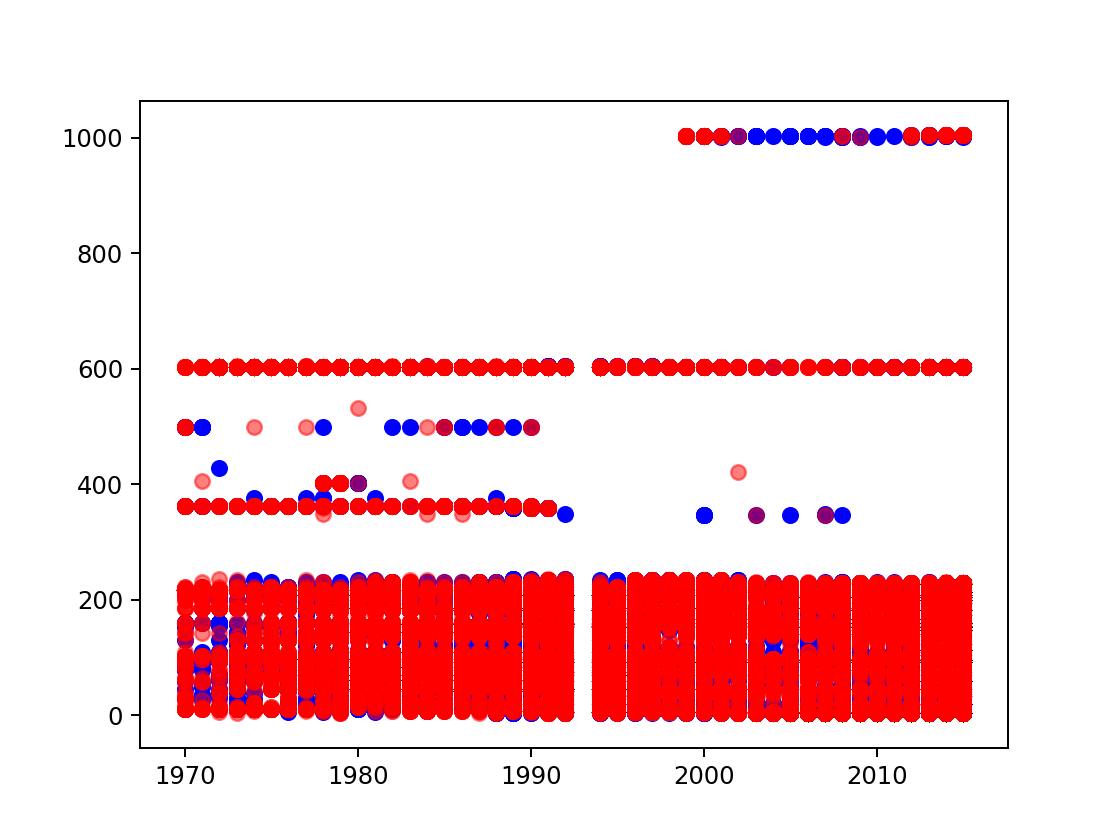

In [5]:
%matplotlib notebook

import matplotlib.pyplot as plt

features = gtd[['country', 'attacktype1', 'iyear']]
unk_features = features[itarget==0]
known_features = features[itarget==1]
fig = plt.figure()
plt.scatter(unk_features['iyear'], unk_features['country'], c='b')
plt.scatter(known_features['iyear'], known_features['country'], c='r', alpha=0.5)


### Step 3. Neural Network classifier
Use a MLP (Multi Layer Perceptron) as a classifier of the group

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(features, itarget, test_size=0.20)

nnet = MLPClassifier(hidden_layer_sizes=(1,))
nnet.fit(X_train, y_train)
nnet.score(X_test, y_test)

0.53940360389092645